## Finding dishes with food in a given dining image

### Uses the following steps to identify image of food in a given image
#### 1. Pick 100 images each of Entree, Dessert, Salad and Non-food to train Scikit-Learn SVC classifier
#### 2. Pre-process all training images by first resizing to a fixed size, then applying edge detection using cv2.Canny function
#### 3. Use HOG function to convert the above image to numerical format to train the SVC classifier
#### 4. Fit all of the 400 images to SVC to train the classifier
#### 5. Preprocess the given input image using cv2.Canny that marks the edges
#### 6. Using cv2.findContours, collects are contour co-ordinates of all contours
#### 7. use each of the contour to predict the trained SVC classifier
#### 8. Draw rectangles of different colors (red=Entry, Green=Salad, Blue=Dessert) around the successfully predicted contours in the original image

### Imports needed from Numpy, OpenCV, sklearn etc

In [42]:
from os import listdir
from os.path import isfile, join
from io import open
from time import time

import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

### List fo labels to train the SVC classifier. These are also the folder names in file system where training samples are stored.

In [43]:
label_list = ["Entree", "Salad", "Dessert", "Non-Food"]

### Utility method that collects all image file paths for all images in a given folder (label)

In [44]:
# Utility method to get all the images for a given label.
# For simplicity, the training and test images are origanized into folders whose name is same as the 
# label name.
def get_file_list_for_label(label):
    """
    Returns the list of files for a given label. Assumes that the images are arranged into
    folders with same name as the labels under '../Data' directory.
    """
    data_file_path = "./Data/Training/" + label
    return [join(data_file_path, f) for f in listdir(data_file_path) if isfile(join(data_file_path, f))]

### Returns 2 lists, one containing the image loaded using cv2 and the second list containing the corresponding label names

In [45]:
# Constructs and returns a list of images and the corresponding labels
# The feature at this point is nothing but the image itself. Later in pre-processing,
# the image content will be reduced into features using HOG.
def get_images_and_labels():
    """
    Returns all the image contents (features), their corresponding label names as 
    two a list of tuples.
    """
    image_label_list = []
    for label in label_list:
        file_list = get_file_list_for_label(label)
        for file in file_list:
            img = cv2.imread(file)
            image_label_list.append((img, label))
    #Shuffle to randomize the data set
    shuffle(image_label_list)
    return image_label_list

### Global image sizes for resizing and HOG declaration

In [46]:
# Initialize the hog descriptor. HOG is the utility to convert image data into numeric histogram data
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

### Utility method to convert all image data into HOG histograms with their corresponding lables. This function does the following pre-processing before apploying HOG
#### 1. Resizes image
#### 2. Applies Canny edge detection

In [47]:
# Utility method to convert list of (image, label) tuples to (HOG histogram, label) tuples
def get_hog_histograms_with_labels(image_label_list, hog, dims):
    data = []
    for img_label in image_label_list:
        # Resize images first into a fixed dimension of 80 * 80
        img = cv2.resize(img_label[0], dims)
        # Apply edge detection using Canny algorithm
        img = cv2.Canny(img,750,150)

        # Compute the HOG histogram for the edge image
        hist = hog.compute(img)
        
        data.append((hist, img_label[1]))
    shuffle(data)
    return map(list, zip(*data))

### Trains the SVC classifier using the HOG histograms as features and image labels as labels.

In [48]:
image_label_list = get_images_and_labels()

X, y = get_hog_histograms_with_labels(image_label_list, hog, dims)

X = [x.flatten() for x in X]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

lsvm = SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(X, y)

#print("test accuracy ", lsvm.score(X_test, y_test))
#y_pred = lsvm.predict(X_test)
#print(classification_report(y_test, y_pred))

#print(confusion_matrix(y_test, y_pred))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Utility method to remove overlapping rectangles (overlapping contours for the same dish) and returns non-overlapping list of rectangles with the largest of the overlapping ones.

In [49]:
def does_overlap(r1, r2):
    x11 = r1[0]
    y11 = r1[1]
    x12 = r1[0] + r1[2]
    y12 = r1[1] + r1[3]

    x21 = r2[0]
    y21 = r2[1]
    x22 = r2[0] + r2[2]
    y22 = r2[1] + r2[3]
    
    cond1 = (x11 > x21 and x11 < x22 and y11 > y21 and y11 < y22)
    cond2 = (x21 > x11 and x21 < x12 and y21 > y11 and y21 < y12)
    #print(r1, r2, cond1, cond2)
    return cond1 or cond2

def area(r):
    return r[2] * r[3]
    
def get_non_intersecting_set(y_result, X_pos):
    """
    When there are intersecting rectangles in X_pos from the contour rectangles, 
    then only the larger of the rectangle is selected along with its label.
    """
    result = []
    for i in range(0, len(X_pos)):
        overlap_found = False
        for j in range(i+1, len(X_pos)):
            A = X_pos[i]
            B = X_pos[j]
            intersects = does_overlap(A, B)
            if intersects:
                overlap_found = True
                if area(A) >= area(B):
                    C = A
                    r = y_result[i]
                else:
                    C = B
                    r = y_result[j]
        if overlap_found == False:
            C = X_pos[i]
            r = y_result[i]
        result.append((r, C))
    return map(list, zip(*result))            

### Main test code to identify the dishes in a given sample dining image using the steps described at the beginning.

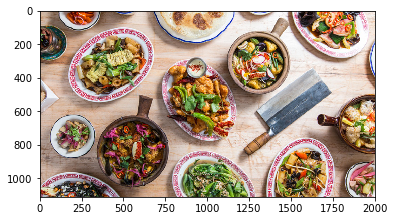

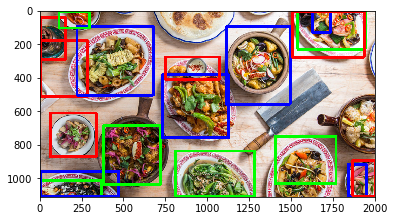

In [50]:
image = cv2.imread("Data/Test/table-3.jpg")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show() 

cnts = cv2.findContours(cv2.Canny(resized,750,150), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

X_test = []
X_pos = []

for c in cnts:
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    #cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(1.2*(x2-x1)),int(1.2*(y2-y1)))
    
    if size[0] >= 150 and size[1] >= 150 and size[0] <= 700 and size[1] <= 700:
        cropped = cv2.getRectSubPix(image, size, center)
        #plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        #plt.show()
        resized_crop = cv2.resize(cropped, dims)
        #plt.imshow(resized_crop)
        #plt.show()
        canny_crop = cv2.Canny(resized_crop,750,150)
        #plt.imshow(canny_crop)
        #plt.show()
        hog_crop = hog.compute(canny_crop)
        X_test.append(hog_crop.flatten())
        X_pos.append(cv2.boundingRect(c))
    
y_result = lsvm.predict(X_test);

y_result, X_pos = get_non_intersecting_set(y_result, X_pos)

for i in range(0, len(y_result)):
    label = y_result[i]
    bound_rect = X_pos[i]
    
    if label == 'Entree':
        color = (255, 0, 0)
    elif label == 'Salad':
        color = (0,255,0)
    elif label == 'Dessert':
        color = (0,0,255)
    else:
        continue
    
    x, y, w, h = bound_rect    
    cv2.rectangle(image, (x,y),(x+w, y+h), color, 15)    

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()    